In [1]:
import numpy as np
from data import generate_embeddings

np.random.seed(56) #36
db_embeddings = generate_embeddings(500, size=2) #500

In [62]:
from random import seed
from knns.hnsw import HNSW

seed(7)
hnsw = HNSW(m=8, ef=1)
hnsw.insert(db_embeddings)

0: 0.0s
100: 0.06399750709533691s
200: 0.09100198745727539s
300: 0.09399843215942383s
400: 0.09800934791564941s


In [64]:
from knns.bkmeans_hnsw import BisectingKmeansHNSW

bhnsw = BisectingKmeansHNSW(m=8, max_clusters=80, ef=1, seed=0)
bhnsw.insert(db_embeddings)

layers selected: 1
layers selected: 9
layers selected: 73
layers selected: 500
0: 0.0s
100: 0.0650014877319336s
200: 0.08900046348571777s
300: 0.09200024604797363s
400: 0.10299968719482422s


In [40]:
from knns.exhaustive import ExhaustiveKnn


knn = ExhaustiveKnn()
knn.insert(db_embeddings)

In [41]:
gold = []
for i, embedding in enumerate(db_embeddings):
    gold.append(knn.search(embedding))
len(gold)

500

In [37]:
import cProfile
import pstats
from time import time
from knns.base import KNNSBase

def get_recall(test_index, search_result):
    gold_result = gold[test_index]
    found = 0
    if search_result[0] in gold_result:
        found += 1
    return found/1

def test_ann(ann:KNNSBase, k=1):
    print(f"Test: algorithm={ann.__class__.__name__}")
    recalls = []
    deltas = []
    distance_calculation_counts = []
    for i, embedding in enumerate(db_embeddings):
        query = embedding
        start = time()
        ann_results = ann.search(query, k)
        end = time()
        recall = get_recall(i, ann_results)
        recalls.append(recall)
        delta = end-start
        deltas.append(delta)
        with cProfile.Profile() as profile:
            ann_results = ann.search(query, k)
        stats = pstats.Stats(profile)
        distance_calculation_count = int(stats.get_stats_profile().func_profiles['get_distance'].ncalls)
        distance_calculation_counts.append(distance_calculation_count)
        print(f"test {i}: recall@{k}={recall} time={round(delta, 4)} distance calculations={distance_calculation_count}")
    avg_recalls = round(sum(recalls)/len(recalls), 4)
    avg_deltas = round(sum(deltas)/len(deltas), 4)
    avg_distance_calculation_counts = round(sum(distance_calculation_counts)/len(distance_calculation_counts), 4)
    print(f"Final results (avg): recall@{k}={avg_recalls} time={avg_deltas} distance calculations={avg_distance_calculation_counts}")
    return recalls, deltas, distance_calculation_counts

In [53]:
recalls, deltas, distance_calculation_counts = test_ann(hnsw)

Test: algorithm=HNSW
test 0: recall@1=1.0 time=0.0 distance calculations=39
test 1: recall@1=1.0 time=0.001 distance calculations=46
test 2: recall@1=1.0 time=0.001 distance calculations=45
test 3: recall@1=1.0 time=0.001 distance calculations=55
test 4: recall@1=1.0 time=0.0 distance calculations=45
test 5: recall@1=1.0 time=0.0 distance calculations=45
test 6: recall@1=1.0 time=0.0 distance calculations=40
test 7: recall@1=1.0 time=0.001 distance calculations=57
test 8: recall@1=1.0 time=0.0 distance calculations=48
test 9: recall@1=1.0 time=0.0 distance calculations=41
test 10: recall@1=1.0 time=0.001 distance calculations=47
test 11: recall@1=1.0 time=0.001 distance calculations=48
test 12: recall@1=1.0 time=0.001 distance calculations=48
test 13: recall@1=1.0 time=0.001 distance calculations=50
test 14: recall@1=1.0 time=0.0 distance calculations=41
test 15: recall@1=1.0 time=0.0 distance calculations=56
test 16: recall@1=1.0 time=0.001 distance calculations=41
test 17: recall@1=1

In [63]:
recalls, deltas, distance_calculation_counts = test_ann(bhnsw)


Test: algorithm=BisectingKmeansHNSW
test 0: recall@1=1.0 time=0.001 distance calculations=45
test 1: recall@1=1.0 time=0.0 distance calculations=40
test 2: recall@1=1.0 time=0.001 distance calculations=44
test 3: recall@1=1.0 time=0.0 distance calculations=39
test 4: recall@1=1.0 time=0.001 distance calculations=40
test 5: recall@1=1.0 time=0.0 distance calculations=35
test 6: recall@1=1.0 time=0.0 distance calculations=32
test 7: recall@1=1.0 time=0.0 distance calculations=39
test 8: recall@1=1.0 time=0.0 distance calculations=34
test 9: recall@1=1.0 time=0.0 distance calculations=48
test 10: recall@1=1.0 time=0.0 distance calculations=44
test 11: recall@1=1.0 time=0.0 distance calculations=41
test 12: recall@1=1.0 time=0.0 distance calculations=39
test 13: recall@1=1.0 time=0.0 distance calculations=46
test 14: recall@1=1.0 time=0.001 distance calculations=39
test 15: recall@1=1.0 time=0.001 distance calculations=34
test 16: recall@1=1.0 time=0.0 distance calculations=45
test 17: rec

In [4]:
from matplotlib import pyplot as plt
from knns.hnsw import HNSW_Graph


def plot_HNSW(g:HNSW_Graph, db, only_layer=None):
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    fig = plt.gcf()
    if only_layer != None:
        fig.set_size_inches(5, 5)
    else:
        fig.set_size_inches(4, 4)

    colors = ['lightgrey', 'red', 'blue', 'green']
    for layer in range(g.height):
        if only_layer==None or layer==only_layer:
            x = []
            y = []
            for index, node in enumerate(g.nodes):
                if node.get_height() > layer:
                    x.append(db[index][0])
                    y.append(db[index][1])
            plt.scatter(x, y, label=f"layer {layer}", c=colors[layer])

    if only_layer != None:
        plt.title(f"layer size = {len(x)}")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.067),
          fancybox=True, shadow=True, ncol=5)
    #plt.savefig("example2.pdf", bbox_inches='tight', facecolor='white')
    plt.show()

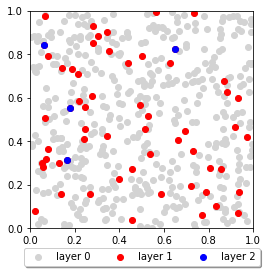

In [47]:
plot_HNSW(hnsw.graph, db_embeddings)

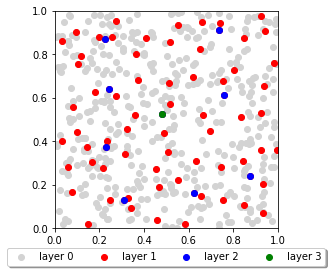

In [20]:
plot_HNSW(bhnsw.graph, db_embeddings)

In [68]:
def plot_clustering(db, labels, only_label=None):
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    fig = plt.gcf()
    if only_label != None:
        fig.set_size_inches(5, 5)
    else:
        fig.set_size_inches(4, 4)

    db_embeddings = np.array(db)
    if only_label == None:
        for i in np.unique(labels):
            plt.scatter(db_embeddings[labels == i , 0] , db_embeddings[labels == i , 1] , label = i)
    else:
        plt.scatter(db_embeddings[labels == only_label , 0] , db_embeddings[labels == only_label , 1] , label = only_label)
        plt.title(f"cluster {only_label}")
    plt.savefig("example3.pdf", bbox_inches='tight', facecolor='white')
    plt.show()

In [66]:
from sklearn.cluster import BisectingKMeans


kmeans = BisectingKMeans(n_clusters=8, random_state=0)
labels = kmeans.fit_predict(db_embeddings)

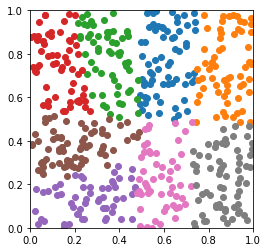

In [69]:
plot_clustering(db_embeddings, labels)

In [112]:
from matplotlib import pyplot as plt
from knns.hnsw import HNSW_Graph


def plot_HNSW2(g:HNSW_Graph, db, only_layer=0, show_centroids=False):
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    fig = plt.gcf()
    fig.set_size_inches(4, 4)

    for index, node in enumerate(g.nodes):
        plt.scatter(db[index][0], db[index][1], c='lightgrey')

    colors = ['lightgrey', 'red', 'blue', 'green']
    for layer in range(g.height):
        if layer >= only_layer:
            x = []
            y = []
            for index, node in enumerate(g.nodes):
                if node.get_height() == layer+1:
                    x.append(db[index][0])
                    y.append(db[index][1])   
            if only_layer == layer:
                sl = len(x)
                #plt.title(f"sl  = {len(x)}")
            if layer > only_layer or not show_centroids:
                plt.scatter(x, y, c=colors[layer])
    if show_centroids:
        kmeans = BisectingKMeans(n_clusters=sl, bisecting_strategy='largest_cluster', random_state=0)
        kmeans.fit(db)
        centroids = kmeans.cluster_centers_

        for centroid in centroids:
            plt.scatter(centroid[0], centroid[1], marker='x', c=colors[only_layer])

    #plt.savefig(f"example4_{only_layer}_{show_centroids}.pdf", bbox_inches='tight', facecolor='white')
    plt.show()

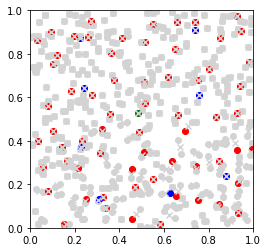

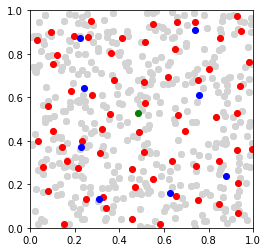

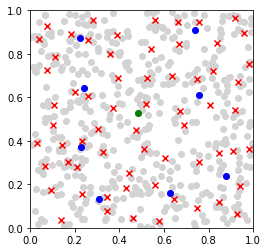

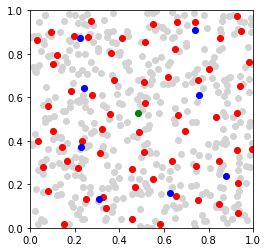

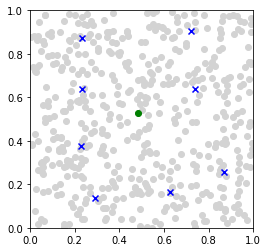

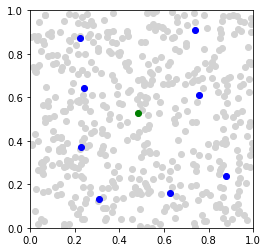

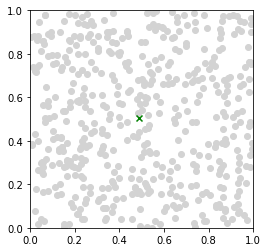

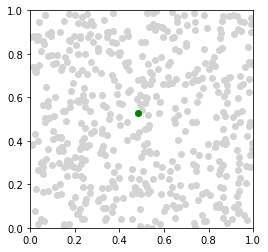

In [113]:
for i in range(bhnsw.graph.height):
    plot_HNSW2(bhnsw.graph, db_embeddings, only_layer=i, show_centroids=True)
    plot_HNSW2(bhnsw.graph, db_embeddings, only_layer=i, show_centroids=False)